In [1]:
#pip install typing-extensions==3.7.4.1

In [2]:
!pip install webrtcvad
import contextlib
import numpy as np
import wave
import librosa
import webrtcvad


def read_wave(path):
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


class Frame(object):
  def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

In [3]:
def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(vad, frames, sample_rate):
    is_speech = []
    for frame in frames:
        is_speech.append(vad.is_speech(frame.bytes, sample_rate))
    return is_speech


def vad(file):
    audio, sample_rate = read_wave(file)
    vad = webrtcvad.Vad(2)
    frames = frame_generator(10, audio, sample_rate)
    frames = list(frames)
    segments = vad_collector(vad, frames, sample_rate)
    return segments

In [4]:
def speech(file):
  dummy = 0
  data = []
  segments = vad(file)
  audio, sr = librosa.load(file)
  for i in segments:
    if i == True:
      data.append(audio[dummy:dummy + 480])
      dummy = dummy + 480
    else:
      dummy = dummy + 480
  data = np.ravel(np.asarray(data))

  return data

def fxn(file):
  segments = vad(file)
  segments = np.asarray(segments)
  dummy = 0.01*np.where(segments[:-1] != segments[1:])[0] +.01
  if len(dummy)%2==0:
    dummy = dummy
  else:
    dummy = np.delete(dummy, len(dummy)-1)

  voice = dummy.reshape(int(len(dummy)/2),2)

  return voice

In [5]:
#pip install keras

In [6]:
import tensorflow
import keras
from keras.layers import *
from keras.models import *
import librosa
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Bidirectional, TimeDistributed, Dropout
from keras.layers import LSTM
import numpy as np
import keras

model = Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

model.build(input_shape=(None, 137, 35))
model.summary()
model.load_weights("/content/model_hindi_2.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 137, 256)            │         167,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 137, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 137, 32)             │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 137, 32)             │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 137, 1)              │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 571,489 (2.18 MB)

 Trainable params: 571,489 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def multi_segmentation(file):
    frame_size = 2048
    frame_shift = 512
    y, sr = librosa.load(file)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, hop_length=frame_shift, n_fft=frame_size)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    mfcc = mfccs[1:, ]
    norm_mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / np.std(mfcc, axis=1, keepdims=True)
    norm_mfcc_delta = (mfcc_delta - np.mean(mfcc_delta, axis=1, keepdims=True)) / np.std(mfcc_delta, axis=1, keepdims=True)
    norm_mfcc_delta2 = (mfcc_delta2 - np.mean(mfcc_delta2, axis=1, keepdims=True)) / np.std(mfcc_delta2, axis=1, keepdims=True)

    ac_feature = np.vstack((norm_mfcc, norm_mfcc_delta, norm_mfcc_delta2))
    print(ac_feature.shape)

    sub_seq_len = int(3.2 * sr / frame_shift)
    sub_seq_step = int(0.8 * sr / frame_shift)

    def extract_feature():
        feature_len = ac_feature.shape[1]
        sub_train_x = []
        for i in range(0, feature_len-sub_seq_len, sub_seq_step):
            sub_seq_x = np.transpose(ac_feature[:, i: i+sub_seq_len])
            sub_train_x.append(sub_seq_x[np.newaxis, :, :])
        return np.vstack(sub_train_x), feature_len

    predict_x, feature_len = extract_feature()
    print(predict_x.shape)

    predict_y = model.predict(predict_x)
    print(predict_y.shape)

    score_acc = np.zeros((feature_len, 1))
    score_cnt = np.ones((feature_len, 1))

    for i in range(predict_y.shape[0]):
        for j in range(predict_y.shape[1]):
            index = i*sub_seq_step+j
            score_acc[index] += predict_y[i, j, 0]
            score_cnt[index] += 1

    score_norm = score_acc / score_cnt

    wStart = 0
    wEnd = 200
    wGrow = 200
    delta = 25

    store_cp = []
    index = 0
    while wEnd < feature_len:
        score_seg = score_norm[wStart:wEnd]
        max_v = np.max(score_seg)
        max_index = np.argmax(score_seg)
        index = index + 1
        if max_v > 0.5:
            temp = wStart + max_index
            store_cp.append(temp)
            wStart = wStart + max_index + 50
            wEnd = wStart + wGrow
        else:
            wEnd = wEnd + wGrow

    seg_point = np.array(store_cp)*frame_shift

    plt.figure('speech segmentation plot')
    plt.plot(np.arange(0, len(y)) / (float)(sr), y, "b-")

    for i in range(len(seg_point)):
        plt.vlines(seg_point[i] / (float)(sr), -1, 1, colors="c", linestyles="dashed")
        plt.vlines(seg_point[i] / (float)(sr), -1, 1, colors="r", linestyles="dashed")
    plt.xlabel("Time/s")
    plt.ylabel("Speech Amp")
    plt.grid(True)
    plt.show()

    return np.asarray(seg_point) / float(sr)

In [8]:
def group_intervals(a):
    a = a.tolist()
    ans = []

    curr = None
    for x in a:
        # no previous interval under consideration
        if curr == None:
          curr = x
        else:
            # check if we can merge the intervals
            if x[0]-curr[1] < 1:
                curr[1] = x[1]
            else:
            # if we cannot merge, push the current element to ans
                ans.append(curr)
                curr = x

        if curr is not None:
            ans.append(curr)

    d1 = np.asarray(ans)
    d2 = np.unique(d1)
    d3 = d2.reshape(int(len(d2)/2),2)
    return d3

In [9]:
def spliting(seg,arr):
  arr1 = arr.tolist()
  temp = arr.copy()

  for i in range(len(seg)-1):
    temp1 = float(seg[i])
    # print(temp1)
    #for j in range(len(arr)-1):
    for j in range(len(arr)):
      if ((temp1 > arr[j][0]) & (temp1 < arr[j][1])):
        arr1[j].insert(-1,(temp1))

  #for i in range(len(arr1-1)):
  for i in range(len(arr1)):
    size=len(arr1[i])
    if size>=3:
      arr1[i].pop(-2) if arr1[i][-1]-arr1[i][-2]<0.2 else True

  return arr1

In [10]:
def final_reseg(arr):
  z=[]
  for i in arr:
    if len(i)==2:
      z.append(i)
    else:
      temp = len(i)
      for j in range(temp-1):
        if j!=temp-1:
          temp1 = [i[j],i[j+1]-0.01]
          z.append(temp1)
        elif j==temp-1:
          temp1 = [i[j],i[j+1]]
          z.append(temp1)

  return np.asarray(z)

In [11]:
#!pip install pyannote.core==4.1 pyannote.pipeline==1.5.2 pyannote.audio==1.1.1
#!wget -nc https://raw.githubusercontent.com/pyannote/pyannote-audio/1.1.1/hubconf.py -P /root/.cache/torch/hub/pyannote_pyannote-audio_main
import torch
import pyannote.core #https://github.com/pyannote/pyannote-audio/issues/561

File ‘/root/.cache/torch/hub/pyannote_pyannote-audio_main/hubconf.py’ already there; not retrieving.



In [12]:
import torch
import librosa
from pyannote.core import Segment

def embeddings_(audio_path,resegmented,range):
  model_emb = torch.hub.load('pyannote/pyannote-audio', 'emb')

  embedding = model_emb({'audio': audio_path})
  for window, emb in embedding:
    assert isinstance(window, Segment)
    assert isinstance(emb, np.ndarray)

  y, sr = librosa.load(audio_path)
  myDict={}
  myDict['audio'] = audio_path
  myDict['duration'] = len(y)/sr

  data=[]
  for i in resegmented:
    excerpt = Segment(start=i[0], end=i[0]+range)
    emb = model_emb.crop(myDict,excerpt)
    data.append(emb.T)
  data= np.asarray(data)

  return data.reshape(len(data),512)

In [13]:
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
scaler = StandardScaler()
def clustering(emb):
  temp = scaler.fit_transform(emb)
  Y = TSNE(n_components=2).fit_transform(temp)
  cluster_ms = MeanShift(bandwidth = 3,max_iter=200,cluster_all=False).fit(Y)
  y_ms = cluster_ms.predict(Y)
  clus_centre = cluster_ms.cluster_centers_
  n_speakers = clus_centre.shape[0]
  plt.figure
  plt.scatter(Y[:,0], Y[:, 1], c=y_ms, s=50, cmap='viridis')
  plt.show()

  return y_ms, n_speakers

In [14]:
from pyannote.core import Annotation, Segment
def hypothesis_gen(hyp_df):
  hyp_records = hyp_df.to_records(index=False)
  hyp_rec = list(hyp_records)
  hypothesis = Annotation()
  for i in range(len(hyp_rec)-1):
    hypothesis[Segment(hyp_rec[i][1], hyp_rec[i][2])] = hyp_rec[i][0]

  return hypothesis

In [15]:
from sklearn import preprocessing
import pandas as pd
def diarization(audiofile):
    voice = fxn(audiofile)
    segmented = multi_segmentation(audiofile)
    gp = group_intervals(voice)
    splt = spliting(segmented,gp)
    resegmented = final_reseg(splt)
    embeddings = embeddings_(audiofile,resegmented,2)
    speak_id , n_speakers = clustering(embeddings)
    label_list = []
    alpha = 'A'
    for i in range(0, n_speakers):
        label_list.append(alpha)
        alpha = chr(ord(alpha) + 1)
    lb = preprocessing.LabelEncoder()
    label_hyp = lb.fit(label_list)
    speaker_id = lb.inverse_transform(speak_id)
    hyp_df = pd.DataFrame({'Speaker_id': speaker_id,'Offset': resegmented[:, 0], 'end': resegmented[:, 1]})
    result_hypo = hypothesis_gen(hyp_df)
    return segmented, n_speakers, hyp_df, result_hypo

In [16]:
!ffmpeg -n -i Hindi1_01.wav -ac 1 mono_hindi1.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [17]:
!ffmpeg -i mono_hindi1.wav -ar 48000 hindi1.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [18]:
#!pip install librosa --upgrade

In [19]:
!pip install pyannote.audio.features

ERROR: Could not find a version that satisfies the requirement pyannote.audio.features (from versions: none)
ERROR: No matching distribution found for pyannote.audio.features


(35, 51912)
(1523, 137, 35)
48/48 ━━━━━━━━━━━━━━━━━━━━ 45s 700ms/step
(1523, 137, 1)


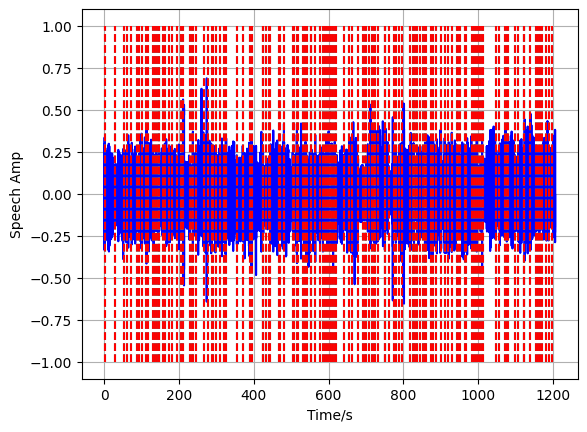

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main
/usr/local/lib/python3.10/dist-packages/pyannote/audio/embedding/approaches/arcface_loss.py:170: FutureWarning: The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


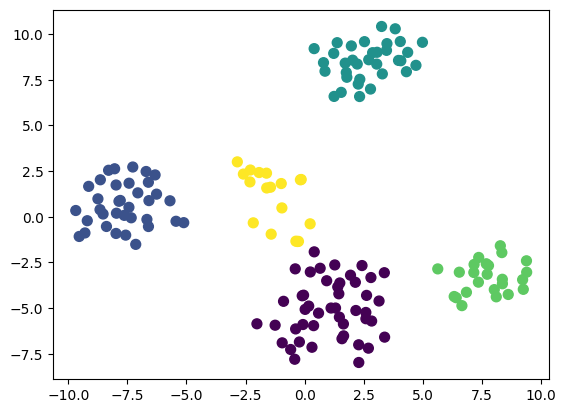

5
    Speaker_id       Offset          end
0            E     0.040000     3.217574
1            E     3.227574    28.759524
2            E    28.769524    53.094036
3            E    53.104036    60.292222
4            B    60.302222    72.552358
..         ...          ...          ...
152          A  1178.480000  1179.470000
153          A  1181.060000  1186.130000
154          A  1187.830000  1189.780476
155          A  1189.790476  1202.110000
156          A  1203.130000  1204.190000

[157 rows x 3 columns]


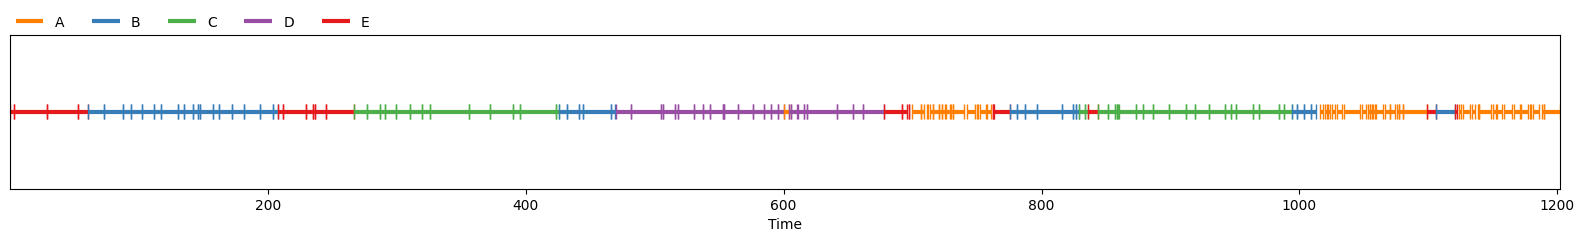

In [20]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindi1.wav")
print(n_clusters)
print(hyp_df)
result_hypo

In [21]:
def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi1_01']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

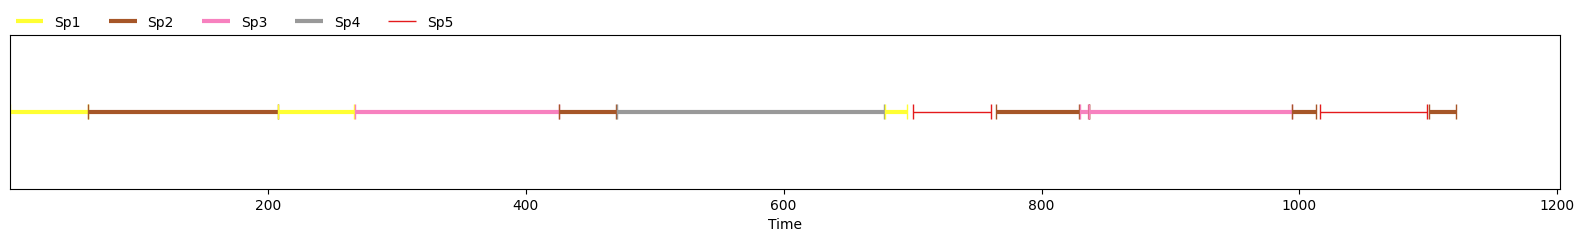

In [22]:
reference, ref_df = reference_gen('/content/annotations1 (1).csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

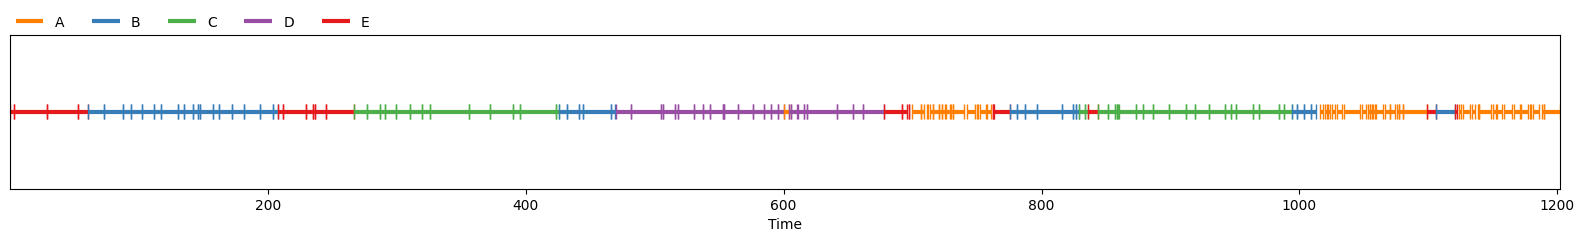

In [23]:
result_hypo

In [24]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.metrics.diarization import DiarizationCoverage
#Upload the annotation file from Google Drive. Change the Path accordingly.
result_ref, ref_df = reference_gen('/content/annotations1 (1).csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.114
Purity = 1.000
Coverage = 1.000


/usr/local/lib/python3.10/dist-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
